In [62]:
import numpy as np, random, math
from scipy.optimize import minimize 
import matplotlib.pyplot as plt

## Generate data

In [459]:
np.random.seed(101)

nrA = 5
classA = np.concatenate((np.random.randn(nrA, 2) * 0.2 + [1.2, 1],
                                np.random.randn(nrA, 2) * 0.2 + [1.2, 1]))
#classA = np.random.randn(nrA, 2) * 0.2 + [1.5, 0.5]
nrB = 5
classB = np.random.randn(nrB , 2) * 0.2 + [0.5 , 0.5]
classB = np.concatenate((classB, np.random.randn(nrB, 2) * 0.2 + [1.7 , 1.7]))

inputs = np.concatenate((classA, classB))
targets = np.concatenate((np.ones(classA.shape[0]), -np.ones(classB.shape[0])))

N = inputs.shape[0] # Number of rows (samples)
permute=list(range(N)) 
random.shuffle(permute)
inputs = inputs[permute, :]
targets = targets[permute]

## Plot the data

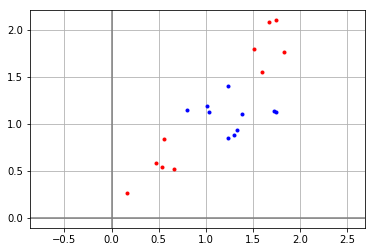

In [460]:
plt.plot([p[0] for p in classA], [p[1] for p in classA], 'b.')
plt.plot([p[0] for p in classB], [p[1] for p in classB], 'r.')
plt.axis('equal')
plt.grid()
plt.axhline(y=0, color='gray')
plt.axvline(x=0, color='gray')
plt.show()

## Let us define som kernel functions

In [461]:
def linearKernel(x, y):
    return np.dot(x, y)

def polynomialKernel(x, y):
    p = 3
    return (np.dot(x, y) + 1)**p

def radialBasisKernel(x, y):
    sigma = 1
    return math.exp(-(np.linalg.norm(x - y)**2) / (2 * (sigma**2)))

## The objective function to minimise

In [462]:
def objective(alpha):
    sum_alpha = np.sum(alpha)
    sum_rest = 0
    for i in range(N):
        for j in range(N):
            sum_rest += alpha[i] * alpha[j] * P[i, j]
    return 0.5 * sum_rest - sum_alpha

## Implement constraint $\sum_{i}^{} \alpha_it_i = 0$

In [463]:
def zerofun(alpha):
    return np.dot(alpha, targets)

## Pre-compute P<sub>i,j</sub> = t<sub>i</sub> t<sub>j</sub> K(x<sub>i</sub>, x<sub>j</sub>)

In [464]:
kernel = radialBasisKernel
P = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        P[i, j] = targets[i] * targets[j] * kernel(inputs[i], inputs[j])
        

## Heart of the program will be the following minimise call

In [465]:
C = None
start = np.zeros(N)
ret = minimize(objective, start, bounds=[(0, C) for b in range(N)], constraints={'type':'eq', 'fun':zerofun})
alpha = ret['x']
success = ret['success']
print("Found solution: " + str(success))

Found solution: True


## Extract the non-zero α values

In [466]:
zeroThreshhold = 10**-5
if C is None:
    nonZeroAlphaBool = (zeroThreshhold <= alpha)
    print("No C set")
else:
    nonZeroAlphaBool = (zeroThreshhold <= alpha)  & (alpha <= C)
    print("C is set")
    
nonZeroAlphas = alpha[nonZeroAlphaBool]
correspondingInputs = inputs[nonZeroAlphaBool]
correspondingTargets = targets[nonZeroAlphaBool]

No C set


## Calculate b using: b = $\sum_{i}^{} \alpha_it_iK(s, x_i) - t_s$ for any SV $s$

In [467]:
b = 0
for i in range(N):
    b += alpha[i] * targets[i] * kernel(correspondingInputs[0], inputs[i])
b = b  - correspondingTargets[0]

## Define the indicator function (which classifies new points)

In [468]:
def indicator(x, y):
    ret = 0
    for i in range(len(nonZeroAlphas)):
        ret += nonZeroAlphas[i] * correspondingTargets[i] * kernel(np.array([x, y]), correspondingInputs[i])
    return ret - b

## Plot the decision boundry

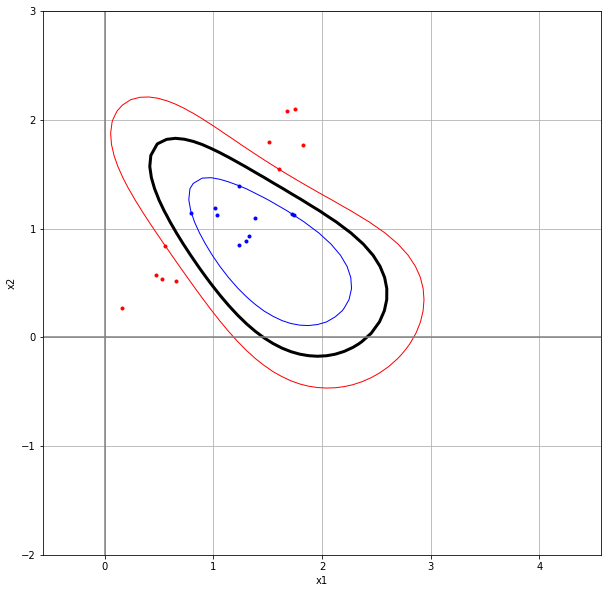

In [469]:
xgrid = np.linspace(-0, 4)
ygrid = np.linspace(-2, 3)
plt.figure(figsize=(10, 10))
grid = np.array([[indicator(x, y) for x in xgrid] for y in ygrid])
plt.axis('equal')
plt.grid()
plt.axhline(y=0, color='gray')
plt.axvline(x=0, color='gray')
plt.contour(xgrid, ygrid, grid, (-1.0, 0.0, 1.0), colors=('red', 'black', 'blue'), linewidths=(1, 3, 1))
plt.plot([p[0] for p in classA], [p[1] for p in classA], 'b.')
plt.plot([p[0] for p in classB], [p[1] for p in classB], 'r.')
plt.xlabel("x1")
plt.ylabel("x2")
plt.savefig("linear_separable")
